In [1]:
import json, os
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
morph = MorphAnalyzer()
stops = set(stopwords.words('russian'))

In [2]:
pd.set_option('display.max_colwidth', 1000)

## Данные

Возьмем данные вот отсюда - https://github.com/mannefedov/ru_kw_eval_datasets Там лежат 4 датасета (статьи с хабра, с Russia Today, Независимой газеты и научные статьи с Киберленинки). Датасет НГ самый маленький, поэтому возьмем его в качестве примера.

In [3]:
# скачаем данные в папке data и распакуем их
PATH_TO_DATA = './data'

In [4]:
files = [os.path.join(PATH_TO_DATA, file) for file in os.listdir(PATH_TO_DATA)]

In [5]:
files 

['./data/.DS_Store', './data/ng_0.jsonlines', './data/ng_1.jsonlines']

Объединим файлы в один датасет.

In [6]:
data = pd.concat([pd.read_json(file, lines=True) for file in files if file != './data/.DS_Store'], axis=0, ignore_index=True)

In [7]:
data.shape

(1987, 5)

In [8]:
data.head(3)

,content,keywords,summary,title,url
0,"Многие интересуются, зачем нужна «Яблоку» молодежная фракция? Основной задачей «Молодежного «Яблока» является привлечение молодых людей к участию в выборах и деятельности партии. «Молодежное «Яблоко» работает более чем в 10 регионах. Единого руководства у нас нет, но мы стараемся координировать свою деятельность и периодически проводим акции на федеральном уровне.\nМы ведем борьбу с обязательным воинским призывом. Военный – это профессия, а не обязанность. Молодые люди вправе сами распоряжаться своей жизнью и не терять целый год, отдавая государству «долг», который они у него не занимали. По мнению одного из ведущих специалистов в области оборонной политики Алексея Арбатова, переход на контрактную армию будет стоить лишь 2% военного бюджета.\nТакже на федеральном уровне «Молодежное «Яблоко» проводило акции за освобождение политзаключенных и против вмешательства России во внутреннюю политику Украины.\nРасскажу о московских активистах. Виктору Петрунину – 19 лет, он пришел к нам боль...","[яблоко, молодежь, молодежное яблоко]",,"""Молодежное ""Яблоко"": оппозиционная деятельность становится опасной",http://www.ng.ru/ng_politics/2017-04-18/11_6976_apple.html
1,"Вчера «Газпром» снизил верхнюю планку прогноза собственной добычи газа в 2020 году. Через 12 лет концерн собирается добывать около 620–640 млрд. куб. м в год. При этом общее производство газа в стране, по расчетам холдинга, должно достичь 940 млрд. куб. м. Иными словами, треть добываемого объема, по мнению холдинга, должны будут обеспечить независимые производители. Эксперты не верят, что независимые компании смогут выйти на такие объемы добычи. Если расчеты «Газпрома» не оправдаются, то под ударом окажутся отечественные предприятия и население, которым придется сокращать потребление и смириться с новым витком цен. Иных путей покрытия возможного дефицита газа нет, так как вряд ли холдинг разорвет уже заключенные контракты на экспорт газа в другие страны. \n«Газпром» к 2020 году планирует добывать 620–640 млрд. куб. м газа, сообщил вчера на форуме «ТЭК России в ХХI веке» глава управления по добыче газа, газового конденсата и нефти холдинга Валерий Минликаев. Тем самым он уточнил пре...","[газпром, газ]",,"""Газпрома"" на всех не хватит",http://www.ng.ru/economics/2008-04-03/1_gazprom.html
2,"Долголетний труд Евгения Витковского на ниве перевода, а также в качестве редактора и антологиста известен многим. Но не все знают его как поэта и прозаика. В этом году уже вышла составленная им и Еленой Кистеровой антология «Раздол туманов: Страницы шотландской гэльской поэзии XVII–XX вв.», а в апреле запланирован выход его романа «Протей, или Византийский кризис» (отрывок из романа читайте на с. 12). С \n побеседовал \n– Одна из таких книг только что вышла – «Раздол туманов. Страницы шотландской гэльской поэзии XVII–XX веков». Это стихи 29 поэтов, все в переводе с оригинала – моем и Елены Кистеровой. Работа заняла 10 лет, включая изучение языка. Она была упоительно интересной: до нас переводов из этой поэзии на русский не было вовсе. Сейчас должен выйти том стихотворений канадского классика Роберта Уильяма Сервиса, «канадского Киплинга», около 300 стихотворений. Кроме того, в Петербурге в производстве наш огромный трехтомный плод совместной работы – антология «Франция в сердце»....","[франсуа рабле, сервантес, шекспир, конан дойл, михаил булгаков, александр грин, борхес, босх, маркес, герман гессе, голландская живопись, гаргантюа и пантагрюэль, дон кихот, мастер и маргарита, москва, россия, история, поэзия, шотландия, баллада, пере]","Евгений Витковский о том, как Босх протягивает руку Шекспиру, \r\nи оба танцуют в пламени пожара в охваченном чумой средневековом городе",Бесконечная партия в четырехмерные шахматы,http://www.ng.ru/person/2018-03-22/10_927_vitkovsky.html


Каждой статье приписано какое-то количество ключевых слов. Допустим, что это единственно правильный набор ключевых слов (что конечно не так, но других данных у нас нет). Наша задача - придумать как извлекать точно такой же список автоматически.  
Зададим несколько метрик, по которым будем определять качество извлекаемых ключевых слов - точность, полноту, ф1-меру и меру жаккарда.

In [84]:
def evaluate(true_kws, predicted_kws):
    assert len(true_kws) == len(predicted_kws)
    
    precisions = []
    recalls = []
    f1s = []
    jaccards = []
    
    for i in range(len(true_kws)):
        true_kw = set(true_kws[i])
        predicted_kw = set(predicted_kws[i])
        
        tp = len(true_kw & predicted_kw)
        union = len(true_kw | predicted_kw)
        fp = len(predicted_kw - true_kw)
        fn = len(true_kw - predicted_kw)
        
        if (tp+fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        
        if (tp+fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)
        if (prec+rec) == 0:
            f1 = 0
        else:
            f1 = (2*(prec*rec))/(prec+rec)
            
        jac = tp / union
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        jaccards.append(jac)
    print('Precision - ', round(np.mean(precisions), 2))
    print('Recall - ', round(np.mean(recalls), 2))
    print('F1 - ', round(np.mean(f1s), 2))
    print('Jaccard - ', round(np.mean(jaccards), 2))
    
    
        

Проверим, что всё работает как надо.

In [13]:
evaluate(data['keywords'], data['keywords'])

Precision -  1.0
Recall -  1.0
F1 -  1.0
Jaccard -  1.0


# Тупое решение.

Давайте не будем думать, а попробуем сразу придумать какое-то решение.

Возьмем первые 5 слов из заголовка.

In [14]:
evaluate(data['keywords'], data['title'].apply(lambda x: x.lower().split()[:5]))

Precision -  0.06
Recall -  0.05
F1 -  0.05
Jaccard -  0.03


Или 10.

In [15]:
evaluate(data['keywords'], data['title'].apply(lambda x: x.lower().split()[:10]))

Precision -  0.06
Recall -  0.06
F1 -  0.05
Jaccard -  0.03


Теперь попробуем взять самые частотные слова.

In [16]:
evaluate(data['keywords'], data['content'].apply(lambda x: 
                                                 [x[0] for x in Counter(x.lower().split()).most_common(10)]))

Precision -  0.02
Recall -  0.04
F1 -  0.02
Jaccard -  0.01


Или вообще рандомные слова.

In [17]:
evaluate(data['keywords'], data['content'].apply(lambda x: 
                                                 np.random.choice(list(set(x.lower().split())), 10)))

Precision -  0.0
Recall -  0.01
F1 -  0.01
Jaccard -  0.0


Теперь давайте посмотрим, что вообще извлекается.

In [18]:
data['title'].apply(lambda x: x.lower().split()[:10]).head(10)

0                         ["молодежное, "яблоко":, оппозиционная, деятельность, становится, опасной]
1                                                                 ["газпрома", на, всех, не, хватит]
2                                                   [бесконечная, партия, в, четырехмерные, шахматы]
3    [экс-депутат,, осужденная, за, фальсификацию, выборов,, оказалась, членом, "боевого, братства"]
4                               [новая, москва, останется, территорией, экологической, безопасности]
5                                [f1., гран-при, сша, прошел, без, четырех, машин, и, со, «стопкой»]
6                                          [100, ведущих, политиков, россии, в, феврале, 2018, года]
7                                               [закон, "о, культуре", принимают, на, фоне, арестов]
8                                    [насколько, реальна, газовая, подоплека, сирийского, конфликта]
9                                  [фсб:, в, калужской, области, задержаны, четверо, участн

In [19]:
data['content'].apply(lambda x: [x[0] for x in Counter(x.lower().split()).most_common(10)]).head(10)

0                                                      [в, и, на, не, что, –, его, «молодежное, с, это]
1                                                            [в, и, на, –, млрд., куб., по, к, газа, м]
2                                                                 [в, –, и, не, я, но, что, это, на, с]
3                                                       [в, на, и, ким, по, –, что, видео, он, зинаиды]
4                                              [в, и, на, новой, площадью, москвы, –, развития, с, для]
5                                                             [в, на, и, не, с, но, уже, что, у, гонки]
6                                                  [на, в, (с, место)., и, рф, позиции, влияние, по, с]
7                                                        [в, и, –, по, с, культуре, не, из, будет, как]
8                                                              [в, и, на, с, что, для, по, –, не, газа]
9    [в, рф, террористической, организации, задержаны, –, четвер

Когда извлекаются частотные слова, то список почти полностью состоит из всяких стоп-слов. Также из-за плохой токенизации некоторые слова в обоих списках - пунктуация или слова с пунктуацией на концах. К тому же извлекаемые слова ненормализованы, а правильные ключевые слова - наоборот.

## Токенизация, удаление стоп-слов и нормализация.

In [9]:
from string import punctuation
from nltk.corpus import stopwords
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words

In [21]:
data['content_norm'] = data['content'].apply(normalize)

In [22]:
data['title_norm'] = data['title'].apply(normalize)

In [23]:
data['title_norm'].head(10)

0            [молодёжный, яблоко, оппозиционный, деятельность, становиться, опасный]
1                                                                 [газпром, хватить]
2                                      [бесконечный, партия, четырехмерный, шахматы]
3    [экс-депутат, осудить, фальсификация, выбор, оказаться, член, боевой, братство]
4                 [новый, москва, остаться, территория, экологический, безопасность]
5                         [f1, гран-при, сша, пройти, четыре, машина, стопка, штраф]
6                                [100, ведущий, политик, россия, февраль, 2018, год]
7                                           [закон, культура, принимать, фон, арест]
8                     [насколько, реальный, газовый, подоплёка, сирийский, конфликт]
9                       [фсб, калужский, область, задержать, четверо, участник, иго]
Name: title_norm, dtype: object

Попробуем те же самые методы.

In [24]:
# топ 10 частотных слов статьи
evaluate(data['keywords'], data['content_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

Precision -  0.11
Recall -  0.22
F1 -  0.14
Jaccard -  0.08


In [25]:
evaluate(data['keywords'],data['title_norm'].apply(lambda x: x[:10]))

Precision -  0.13
Recall -  0.13
F1 -  0.12
Jaccard -  0.07


Качество сильно улучшилось! Можно теперь ещё раз посмотреть, что плохого извлекается.

In [26]:
data['content_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(20)

0                         [яблоко, молодёжный, который, акция, год, активист, это, деятельность, политика, наш]
1                               [миллиард, газа, год, куб, метр, газпром, добыча, 2020, должный, производитель]
2                                              [год, это, книга, роман, тот, писать, выйти, один, мир, перевод]
3                                    [ким, зинаида, видео, год, журналист, суд, дело, бывший, футиный, который]
4                         [площадь, территория, новый, москва, га, который, столица, тинао, парковый, развитие]
5                                  [гонка, который, команда, место, позиция, два, один, из-за, круг, чемпионат]
6                        [место, влияние, рф, позиция, глава, россия, президент, сергей, политический, рейтинг]
7                 [культура, закон, который, сфера, стд, разработать, концепция, проект, изменение, сообщество]
8                              [газопровод, сирия, год, турция, газа, россия, европа, катар, который, ту

Ещё остались некоторые стоп-слова. Вместо того, чтобы расширять список, давайте попробуем выкинуть несуществительные.

In [86]:
def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0] for word in words if word and word not in stops]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']

    return words

In [28]:
data['content_norm'] = data['content'].apply(normalize)

In [29]:
evaluate(data['keywords'], data['content_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

Precision -  0.13
Recall -  0.25
F1 -  0.16
Jaccard -  0.1


Ещу улучшения!

In [30]:
data['content_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(10)

0        [яблоко, акция, год, активист, деятельность, политика, власть, задача, молодая, человек]
1               [миллиард, газа, год, куб, метр, газпром, добыча, производитель, страна, прогноз]
2                [год, книга, роман, мир, перевод, стихотворение, читатель, жанр, поэзия, работа]
3                     [ким, зинаида, видео, год, журналист, суд, дело, рубль, процесс, заседание]
4                   [площадь, территория, москва, га, столица, тинао, развитие, парка, парк, год]
5                    [гонка, команда, место, позиция, круг, чемпионат, пилот, бокс, заезд, льюис]
6               [место, влияние, рф, позиция, глава, россия, президент, сергей, рейтинг, участие]
7    [культура, закон, сфера, концепция, проект, изменение, сообщество, услуга, учреждение, дело]
8                    [газопровод, сирия, год, турция, газа, россия, европа, катар, поток, проект]
9                 [участник, рф, организация, государство, область, центр, связь, фсб, март, год]
Name: content_norm, 

Не очень значимые слова все ещё остались. Давайте попробуем отсеять стоп-слова с помощью tfidf.

Воспользуемся TfidfVectorizer.

In [31]:
data['content_norm_str'] = data['content_norm'].apply(' '.join)

In [32]:
# можно заодно сделать нграммы
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)

In [33]:
tfidf.fit(data['content_norm_str'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [34]:
id2word = {i:word for i,word in enumerate(tfidf.get_feature_names())}

Преобразуем наши тексты в векторы, где на позиции i стоит tfidf коэффициент слова i из словаря.

In [35]:
texts_vectors = tfidf.transform(data['content_norm_str'])

Отсортируем векторы текстов по этим коэффициентам и возьмем топ-10.

In [36]:
# сортировка по убыванию, поэтому нужно развернуть список
keywords = [[id2word[w] for w in top] for top in texts_vectors.toarray().argsort()[:,:-11:-1]] 

In [37]:
keywords[:3]

[['яблоко',
  'активист',
  'акция',
  'дарья',
  'деятельность',
  'молодая человек',
  'политика',
  'виктор',
  'тимур',
  'репрессия'],
 ['миллиард куб',
  'куб метр',
  'куб',
  'газпром',
  'газа',
  'миллиард',
  'добыча',
  'добыча газа',
  'метр',
  'холдинг'],
 ['роман',
  'книга',
  'жанр',
  'стихотворение',
  'читатель',
  'перевод',
  'год',
  'поэзия',
  'произведение',
  'том']]

In [38]:
evaluate(data['keywords'], keywords)

Precision -  0.13
Recall -  0.25
F1 -  0.16
Jaccard -  0.09


Результат ещё немного улучшился. Немного подросла точность. Теперь вместо стоп-слов в ключевые попадают имена и все такое. Иногда это хорощо, а иногда нет (собянин - может быть ключевым словом, а дарья - вряд ли)

Возьмем этот результат за baseline. 

Precision -  0.13
Recall -  0.24
F1 -  0.16
Jaccard -  0.09

## Попробуем графы!

Большая часть методов для извлечения ключевых слов основана на применении графов. Основная идея - каким-то образом перевести текст в граф, а затем каким-то образом расчитать важность каждого узла и вывести топ-N самых важных узлов.  

Перевод текста в граф -  не тривиальная задача. Часто применяют такой подход - построим матрицу совстречаемости слов (в каком-то окне), эта матрица будет нашей матрицей смежности.

Для выбора важных узлов часто используют простой randow walk. Алгоритм примерно такой:  
1) Каким-то образом выбирается первый узел графа (например, случайно из равномерного распределения)  
2) на основе связей этого узла с другими, выбирается следующий узел  
3) шаг два повторяется некоторое количество раз (например, тысячу) __*чтобы не зацикливаться, с какой-то вероятностью мы случайно перескакиваем на другой узел (даже если он никак не связан с текущим, как в шаге 1)__  
5) на каждом шаге мы сохраняем узел в котором находимся  
6) в конце мы считаем в каких узлах мы были чаще всего и выводим top-N  


Предполагается, что мы часто будем приходить в важные узлы графа.

In [10]:
from itertools import combinations

Для наглядности реализуем этот подход без networkx. 

In [69]:
def get_kws(text, top=5, window_size=5, random_p=0.1):

    vocab = set(text)
    word2id = {w:i for i, w in enumerate(vocab)}
    id2word = {i:w for i, w in enumerate(vocab)}
    # преобразуем слова в индексы для удобства
    ids = [word2id[word] for word in text]

    # создадим матрицу совстречаемости
    m = np.zeros((len(vocab), len(vocab)))

    # пройдемся окном по всему тексту
    for i in range(0, len(ids), window_size):
        window = ids[i:i+window_size]
        # добавим единичку всем парам слов в этом окне
        for j, k in combinations(window, 2):
            # чтобы граф был ненаправленный 
            m[j][k] += 1
            m[k][j] += 1
    
    # нормализуем строки, чтобы получилась вероятность перехода
    for i in range(m.shape[0]):
        m[i] /= np.sum(m[i])
    
    # случайно выберем первое слова, а затем будет выбирать на основе полученых распределений
    # сделаем так 5 раз и добавим каждое слово в счетчик
    # чтобы не забиться в одном круге, иногда будет перескакивать на случайное слово
    
    c = Counter()
    # начнем с абсолютного случайно выбранного элемента
    n = np.random.choice(len(vocab))
    for i in range(500): # если долго считается, можно уменьшить число проходов
        
        # c вероятностью random_p 
        # перескакиваем на другой узел
        go_random = np.random.choice([0, 1], p=[1-random_p, random_p])
        if go_random:
            n = np.random.choice(len(vocab))
        
        n = take_step(n, m)
        # записываем узлы, в которых были
        c.update([n])
    
    # вернем топ-N наиболее часто встретившихся сл
    return [id2word[i] for i, count in c.most_common(top)]

def take_step(n, matrix):
    rang = len(matrix[n])
    # выбираем узел из заданного интервала, на основе распределения из матрицы совстречаемости
    next_n = np.random.choice(range(rang), p=matrix[n])
    return next_n
    


In [75]:
%%time
keywords_rw = data['content_norm'].apply(lambda x: get_kws(x, 10, 10))

CPU times: user 1min 10s, sys: 4 ms, total: 1min 10s
Wall time: 1min 10s


In [79]:
evaluate(data['keywords'], keywords_rw)

Precision -  0.11
Recall -  0.21
F1 -  0.14
Jaccard -  0.08


In [67]:
keywords_rw.head(10)

0             [пора, насилие, цикл, акция, декриминализация, новое, ставрополец, яблоко, власть, виктор]
1                           [куб, ямал, миллиард, триллион, страна, год, метр, запас, кубометр, холдинг]
2                           [полночь, сериал, рецензия, дата, открытие, витта, земля, роман, книга, мир]
3     [монтаж, видеодоказательство, видео, экспертиза, визит, кадр, участник, позиция, свидетель, слово]
4               [освоение, тинао, территория, площадь, парка, га, конкурс, забота, пространство, власть]
5          [контакт, превышение, р.грожан, гонка, трасса, переговоры, участие, круг, время, отстранение]
6                      [34-го, андрей, место, ширман, влияние, избиение, глава, дело, россия, свидетель]
7    [расположение, интеллигенция, закон, заместитель, документ, услуга, внесение, сфера, акт, политика]
8                        [монархия, сирия, катар, газопровод, европа, турция, россия, год, иран, регион]
9                 [рф, округа, житель, участник, ислами

Попбруем теперь важность считать с помощью какой-нибудь метрики из networkx.

In [11]:
import networkx as nx

In [71]:
def build_matrix(text, window_size=5):
    vocab = set(text)
    word2id = {w:i for i, w in enumerate(vocab)}
    id2word = {i:w for i, w in enumerate(vocab)}
    # преобразуем слова в индексы для удобства
    ids = [word2id[word] for word in text]

    # создадим матрицу совстречаемости
    m = np.zeros((len(vocab), len(vocab)))

    # пройдемся окном по всему тексту
    for i in range(0, len(ids), window_size):
        window = ids[i:i+window_size]
        # добавим единичку всем парам слов в этом окне
        for j, k in combinations(window, 2):
            # чтобы граф был ненаправленный 
            m[j][k] += 1
            m[k][j] += 1
    
    return m, id2word

def some_centrality_measure(text, window_size=5, topn=5):
    
    matrix, id2word = build_matrix(text, window_size)
    G = nx.from_numpy_array(matrix)
    # тут можно поставить любую метрику
    node2measure = dict(nx.degree(G))
    
    return [id2word[index] for index,measure in sorted(node2measure.items(), key=lambda x: -x[1])[:topn]]

In [77]:
%%time
keyword_nx = data['content_norm'].apply(lambda x: some_centrality_measure(x, 10, 10))

CPU times: user 15.1 s, sys: 32 ms, total: 15.1 s
Wall time: 15.1 s


In [78]:
evaluate(data['keywords'], keyword_nx)

Precision -  0.12
Recall -  0.24
F1 -  0.16
Jaccard -  0.09


Результаты не превосходят tfidf, но и не сильно уступают. Явно можно что-то доработать и превзойти baseline.

## Домашнее задание

В семинаре установлен такой бейзлан - F1 -  0.16 (не будем учитывать точность и полноту по отдельности и отбросим жаккара).

**Ваша задача - предложить 3 способа побить бейзлайн. **

Нет никаких ограничений кроме:

1) нельзя изменять метрику
2) решение должно быть воспроизводимым

В качестве ответа нужно предоставить jupyter тетрадку с экспериментами (обязательное условие!) и описать каждую из идей в форме - https://goo.gl/forms/H9lBH9wCxqq1T0ru2

Каждый реализованный и описанный способ оценивается в 3 балла. Дополнительный балл можно получить, если способы затрагивают разные аспекты решения (например, первая идея - улучшить нормализацию, вторая - улучшить способ представления текста в виде графа, третья - предложить способ удаления из топа идентичных ключевых слов (рф, россия)).

Можно использовать мой код как основу, а можно придумать что-то полностью другой.

Если у вас никак не получается побить бейзлайн вы можете предоставить реализацию и описание неудавшихся экспериментов (каждый оценивается в 0.5 баллов).

In [266]:
data.head()

,content,keywords,summary,title,url
0,"Многие интересуются, зачем нужна «Яблоку» молодежная фракция? Основной задачей «Молодежного «Яблока» является привлечение молодых людей к участию в выборах и деятельности партии. «Молодежное «Яблоко» работает более чем в 10 регионах. Единого руководства у нас нет, но мы стараемся координировать свою деятельность и периодически проводим акции на федеральном уровне.\nМы ведем борьбу с обязательным воинским призывом. Военный – это профессия, а не обязанность. Молодые люди вправе сами распоряжаться своей жизнью и не терять целый год, отдавая государству «долг», который они у него не занимали. По мнению одного из ведущих специалистов в области оборонной политики Алексея Арбатова, переход на контрактную армию будет стоить лишь 2% военного бюджета.\nТакже на федеральном уровне «Молодежное «Яблоко» проводило акции за освобождение политзаключенных и против вмешательства России во внутреннюю политику Украины.\nРасскажу о московских активистах. Виктору Петрунину – 19 лет, он пришел к нам боль...","[яблоко, молодежь, молодежное яблоко]",,"""Молодежное ""Яблоко"": оппозиционная деятельность становится опасной",http://www.ng.ru/ng_politics/2017-04-18/11_6976_apple.html
1,"Вчера «Газпром» снизил верхнюю планку прогноза собственной добычи газа в 2020 году. Через 12 лет концерн собирается добывать около 620–640 млрд. куб. м в год. При этом общее производство газа в стране, по расчетам холдинга, должно достичь 940 млрд. куб. м. Иными словами, треть добываемого объема, по мнению холдинга, должны будут обеспечить независимые производители. Эксперты не верят, что независимые компании смогут выйти на такие объемы добычи. Если расчеты «Газпрома» не оправдаются, то под ударом окажутся отечественные предприятия и население, которым придется сокращать потребление и смириться с новым витком цен. Иных путей покрытия возможного дефицита газа нет, так как вряд ли холдинг разорвет уже заключенные контракты на экспорт газа в другие страны. \n«Газпром» к 2020 году планирует добывать 620–640 млрд. куб. м газа, сообщил вчера на форуме «ТЭК России в ХХI веке» глава управления по добыче газа, газового конденсата и нефти холдинга Валерий Минликаев. Тем самым он уточнил пре...","[газпром, газ]",,"""Газпрома"" на всех не хватит",http://www.ng.ru/economics/2008-04-03/1_gazprom.html
2,"Долголетний труд Евгения Витковского на ниве перевода, а также в качестве редактора и антологиста известен многим. Но не все знают его как поэта и прозаика. В этом году уже вышла составленная им и Еленой Кистеровой антология «Раздол туманов: Страницы шотландской гэльской поэзии XVII–XX вв.», а в апреле запланирован выход его романа «Протей, или Византийский кризис» (отрывок из романа читайте на с. 12). С \n побеседовал \n– Одна из таких книг только что вышла – «Раздол туманов. Страницы шотландской гэльской поэзии XVII–XX веков». Это стихи 29 поэтов, все в переводе с оригинала – моем и Елены Кистеровой. Работа заняла 10 лет, включая изучение языка. Она была упоительно интересной: до нас переводов из этой поэзии на русский не было вовсе. Сейчас должен выйти том стихотворений канадского классика Роберта Уильяма Сервиса, «канадского Киплинга», около 300 стихотворений. Кроме того, в Петербурге в производстве наш огромный трехтомный плод совместной работы – антология «Франция в сердце»....","[франсуа рабле, сервантес, шекспир, конан дойл, михаил булгаков, александр грин, борхес, босх, маркес, герман гессе, голландская живопись, гаргантюа и пантагрюэль, дон кихот, мастер и маргарита, москва, россия, история, поэзия, шотландия, баллада, пере]","Евгений Витковский о том, как Босх протягивает руку Шекспиру, \r\nи оба танцуют в пламени пожара в охваченном чумой средневековом городе",Бесконечная партия в четырехмерные шахматы,http://www.ng.ru/person/2018-03-22/10_927_vitkovsky.html
3,"В Ленинском районном суде продолжаются слушания по делу экс-депутата Думы Владивостока Зинаиды Ким и бывшего председателя избирательного участка № 522 Елены Футиной, которых обви

In [12]:
def evaluate(true_kws, predicted_kws):
    assert len(true_kws) == len(predicted_kws)
    
    precisions = []
    recalls = []
    f1s = []
    jaccards = []
    
    for i in range(len(true_kws)):
        true_kw = set(true_kws[i])
        predicted_kw = set(predicted_kws[i])
        
        tp = len(true_kw & predicted_kw)
        union = len(true_kw | predicted_kw)
        fp = len(predicted_kw - true_kw)
        fn = len(true_kw - predicted_kw)
        
        if (tp+fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        
        if (tp+fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)
        if (prec+rec) == 0:
            f1 = 0
        else:
            f1 = (2*(prec*rec))/(prec+rec)
            
        jac = tp / union
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        jaccards.append(jac)
    return round(np.mean(f1s), 2)
  

## Улучшение нормализации

score - 0.16

In [21]:
import nltk
from nltk import word_tokenize
import string

In [18]:
def preprocessing(text):
    
    global stops

    sentences = nltk.sent_tokenize(text.lower())
    sentences = [word_tokenize(sent) for sent in sentences]
    words = [x.strip(string.punctuation+'»«–…') for sent in sentences for x in sent]
    words = [morph.parse(word)[0] for word in words if word]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN' or word.tag.POS == 'ADJF']
    words = [word for word in words if word not in stops]
    return words
    

##### На тексте

In [317]:
data['content_norm2'] = data['content'].apply(preprocessing)

In [318]:
evaluate(data['keywords'], data['content_norm2'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.15

In [319]:
data['content_norm2'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(10)

0                           [яблоко, молодёжный, который, акция, год, активист, деятельность, свой, политика, весь]
1                                 [миллиард, газа, год, куб, метр, газпром, добыча, производитель, который, страна]
2                                    [год, весь, книга, роман, мир, перевод, стихотворение, читатель, жанр, поэзия]
3                                        [ким, зинаида, видео, год, журналист, суд, дело, бывший, футиный, который]
4                                [площадь, территория, новый, москва, га, который, столица, тинао, развитие, парка]
5                           [гонка, который, команда, место, позиция, круг, чемпионат, пилот, последний, следующий]
6                            [место, влияние, рф, позиция, глава, россия, президент, сергей, политический, рейтинг]
7                 [культура, закон, который, сфера, концепция, проект, изменение, сообщество, услуга, общественный]
8                                  [газопровод, сирия, год, турция, газа

##### На тайтлах

In [320]:
data['title_norm2'] = data['title'].apply(preprocessing)

In [321]:
evaluate(data['keywords'], data['title_norm2'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.13

In [322]:
data['title_norm2'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(10)

0     [молодёжный, яблоко, оппозиционный, деятельность, опасный]
1                                                [газпром, весь]
2                  [бесконечный, партия, четырехмерный, шахматы]
3    [экс-депутат, фальсификация, выбор, член, боевой, братство]
4       [новый, москва, территория, экологический, безопасность]
5                         [гран-при, сша, машина, стопка, штраф]
6                       [ведущий, политик, россия, февраль, год]
7                                  [закон, культура, фон, арест]
8                      [газовый, подоплёка, сирийский, конфликт]
9                       [фсб, калужский, область, участник, иго]
Name: title_norm2, dtype: object

##### А что если их соединить? 

In [14]:
data['tit_text'] = data.content.astype(str).str.cat(data.title.astype(str), sep='\n')

In [22]:
data['content_tit_norm'] = data['tit_text'].apply(preprocessing)
evaluate(data['keywords'], data['content_tit_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.16

In [325]:
data['content_tit_norm'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(10)

0                  [яблоко, молодёжный, который, акция, год, активист, деятельность, свой, политика, весь]
1                        [миллиард, газа, год, куб, газпром, метр, добыча, производитель, который, страна]
2                           [год, весь, книга, роман, мир, перевод, стихотворение, читатель, жанр, поэзия]
3                               [ким, зинаида, видео, год, журналист, суд, дело, бывший, футиный, который]
4                       [территория, новый, москва, площадь, га, который, столица, тинао, развитие, парка]
5                  [гонка, который, команда, место, позиция, круг, чемпионат, пилот, последний, следующий]
6                   [место, влияние, рф, позиция, глава, россия, президент, сергей, политический, рейтинг]
7        [культура, закон, который, сфера, концепция, проект, изменение, сообщество, услуга, общественный]
8                         [газопровод, сирия, год, турция, газа, россия, европа, катар, который, турецкий]
9    [участник, рф, террористический,

#### Расширение списка частотных слов

In [15]:
stops |= {'это', 'тот', 'один', 'из-за', 'который'}

In [23]:
all_ = Counter([])
for lst in data['content_tit_norm'] :
    all_ += Counter(lst)

Возьмем первую сотню

In [328]:
new_stops = [i[0] for i in all_.most_common(100)]

In [329]:
stops |= set(new_stops)

In [330]:
data['content_norm3'] = data['tit_text'].apply(preprocessing)
evaluate(data['keywords'], data['content_norm3'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.15

In [331]:
data['content_norm3'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]).head(10)

0           [яблоко, молодёжный, акция, активист, деятельность, московский, задача, молодая, выборы, виктор]
1               [газа, куб, газпром, метр, добыча, производитель, независимый, внутренний, прогноз, холдинг]
2           [роман, перевод, стихотворение, читатель, жанр, поэзия, произведение, герой, мениппея, редактор]
3                     [ким, зинаида, видео, журналист, суд, бывший, футиный, фальсификация, рубль, судебный]
4                         [площадь, га, столица, тинао, парка, парк, зелёный, зона, департамент, московский]
5                            [гонка, команда, круг, чемпионат, пилот, следующий, машина, бокс, заезд, льюис]
6            [влияние, сергей, рейтинг, участие, политик, исследование, институт, фон, александр, сообщение]
7    [культура, закон, сфера, концепция, изменение, сообщество, услуга, общественный, учреждение, искусство]
8                      [газопровод, сирия, турция, газа, европа, катар, турецкий, поток, газовый, сирийский]
9       [участник, 

Только на текстах

In [333]:
data['content_norm4'] = data['content'].apply(preprocessing)
evaluate(data['keywords'], data['content_norm4'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.15

##### Влияние кол-ва предсказываемых слов

In [39]:
import matplotlib.pyplot as plt

In [36]:
def my_plot(n, data, position):
    
    res = {}
    
    for i in range(1, n+1):
        score = evaluate(data['keywords'], position.apply(lambda x: [x[0] for x in Counter(x).most_common(i)]))
        res[i] = score
    fig = plt.figure()
    plt.plot(res.keys(), res.values())
    plt.show()
        
        

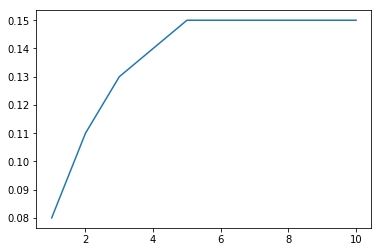

In [354]:
my_plot(10, data, data['content_norm2'])

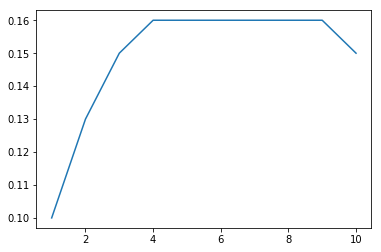

In [338]:
my_plot(10, data, data['content_norm3'])

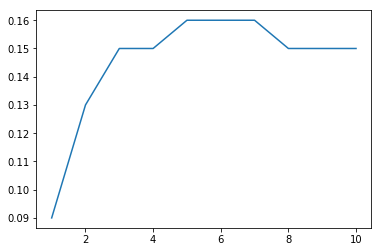

In [339]:
my_plot(10, data, data['content_norm4'])

Следовательно: оптимальное кол-во слов - 5-7

##### Влияние кол-ва добавляемых слов в список стоп-слов

In [37]:
def my_plot2(n, data, position, func, l=5):
    
    global stops
    res = {}
    a = data[position].apply(func)
    score = evaluate(data['keywords'], a.apply(lambda x: [x[0] for x in Counter(x).most_common(l)]))
    res[0] = score
    
    for i in range(10, n, 20):
        new_stops = [i[0] for i in all_.most_common(i)]
        stops |= set(new_stops)
        a = data[position].apply(func)
        score = evaluate(data['keywords'], a.apply(lambda x: [x[0] for x in Counter(x).most_common(l)]))
        res[i] = score
    fig = plt.figure()
    plt.plot(res.keys(), res.values())
    plt.show()
        
        

100
100
100
100
100


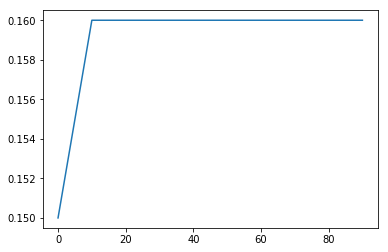

In [355]:
my_plot2(100, data, 'content', preprocessing)

In [359]:
stops = set(stopwords.words('russian'))

100
100
100
100
100


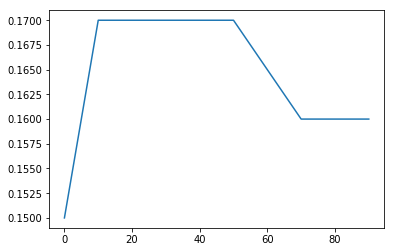

In [357]:
my_plot2(100, data, 'tit_text', preprocessing)

Отимальное число добавляемых слов в список стоп слов - 10-50

In [24]:
new_stops = [i[0] for i in all_.most_common(10)]
stops |= set(new_stops)

data['content_norm4'] = data['tit_text'].apply(preprocessing)
evaluate(data['keywords'], data['content_norm4'].apply(lambda x: [x[0] for x in Counter(x).most_common(5)]))

0.17

## Способ удаления из топа идентичных ключевых слов (рф, россия))

Возьмем отсюда длинные и короткие названия стран мира https://goo.gl/gcauFZ, добавим свои сокращения и регулярками заменим названия в тексте.

In [25]:
import requests
from collections import defaultdict
import re
from bs4 import BeautifulSoup

In [26]:
req = requests.get('https://goo.gl/gcauFZ')
html = req.text
soup = BeautifulSoup(html, 'lxml')
long_short = defaultdict(str)

for i in soup.find_all('tr'):
    long = i.find_all('a', attrs={'class':'mw-redirect'}) # полное
    short = i.find_all('span', attrs={'class':'flagicon'}) # краткое

    if short != []:
        if long != []:
            name = short[0].find_all('a')[0].get('title')
            name = re.sub('\(.*?\)', '', name)
            long_name = re.sub('\(.*?\)', '', long[0].get('title'))
            long_short[long_name.lower()] = name.lower()

In [27]:
long_short['соединённые штаты америки'] = 'америка'
long_short['сша'] = 'америка'
long_short['рф'] = 'россия'
long_short['кндр'] = 'корея'
long_short['кнр'] = 'китай'
long_short['мнр'] = 'монголия'
long_short['нрб'] = 'болгария'
long_short['пнр'] = 'польша'

In [28]:
reg = ''
for index, name in enumerate(long_short):
    if index != len(long_short) - 1:
        reg += name + '|'
    else:
        reg += name

In [29]:
def preprocessing2(text):
    
    global stops, long_short
    
    text = text.lower()
    arr = set(re.findall(reg, text))
    if arr != set():
        for name in arr:
            text = re.sub(name, long_short[name], text)

    sentences = nltk.sent_tokenize(text.lower())
    sentences = [word_tokenize(sent) for sent in sentences]
    words = [x.strip(string.punctuation+'»«–…') for sent in sentences for x in sent]
    words = [morph.parse(word)[0] for word in words if word]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN' or word.tag.POS == 'ADJF']
    words = [word for word in words if word not in stops]
    return words
    

С расширенным списком стоп-слов

На текстах

In [369]:
data['content_norm5'] = data['content'].apply(preprocessing2)
evaluate(data['keywords'], data['content_norm5'].apply(lambda x: [x[0] for x in Counter(x).most_common(5)]))

0.15

In [370]:
data['content_norm5'].apply(lambda x: [x[0] for x in Counter(x).most_common(5)]).head(10)

0                  [яблоко, молодёжный, акция, активист, деятельность]
1                                 [миллиард, газа, куб, метр, газпром]
2                          [книга, роман, мир, перевод, стихотворение]
3                                [ким, зинаида, видео, журналист, суд]
4                             [площадь, территория, новый, москва, га]
5                               [гонка, команда, место, позиция, круг]
6                          [место, влияние, позиция, глава, президент]
7                          [культура, закон, сфера, концепция, проект]
8                            [газопровод, сирия, турция, газа, европа]
9    [участник, террористический, организация, исламский, государство]
Name: content_norm5, dtype: object

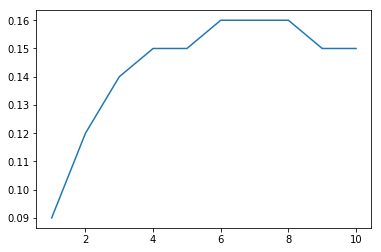

In [373]:
my_plot(10, data, data['content_norm5'])

На тайтлах + текст

In [380]:
new_stops = [i[0] for i in all_.most_common(10)]
stops |= set(new_stops)

In [30]:
data['content_norm6'] = data['tit_text'].apply(preprocessing2)

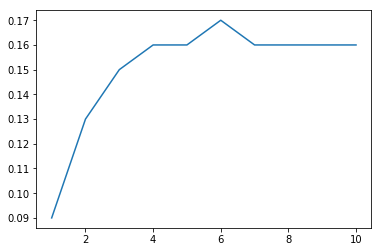

In [385]:
my_plot(10, data, data['content_norm6'])

In [31]:
evaluate(data['keywords'], data['content_norm6'].apply(lambda x: [x[0] for x in Counter(x).most_common(6)]))

0.17

In [ ]:
my_plot2(100, data, 'tit_text', preprocessing2, l=6)

На базовом списке стоп-слов

In [375]:
stops = set(stopwords.words('russian'))
stops |= {'это', 'тот', 'один', 'из-за', 'который'}

In [377]:
x = data['tit_text'].apply(preprocessing2)

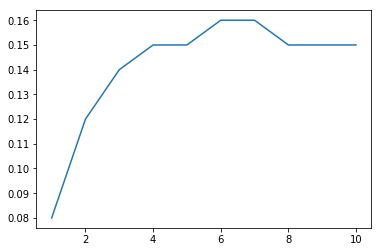

In [378]:
my_plot(10, data, x)

In [379]:
evaluate(data['keywords'], x.apply(lambda x: [x[0] for x in Counter(x).most_common(7)]))

0.16

## N-gram

Без лемматизации

In [32]:
def bigram(text):
    
    global stops, long_short, long, lemm
    
    if long:
        text = text.lower()
        arr = set(re.findall(reg, text))
        if arr != set():
            for name in arr:
                text = re.sub(name, long_short[name], text)
    
    sentences = nltk.sent_tokenize(text.lower())
    sentences = [word_tokenize(sent) for sent in sentences]
    words = [x.strip(string.punctuation+'»«–…') for sent in sentences for x in sent]
    words = [morph.parse(word)[0] for word in words if word]
    
    if lemm:
        words = [word.normal_form for word in words if word.tag.POS == 'NOUN' or word.tag.POS == 'ADJF']
    else:
        words = [word.word for word in words if word.tag.POS == 'NOUN' or word.tag.POS == 'ADJF']
    words = [word for word in words if word not in stops]
    bigrm = [i[0] + ' ' + i[1] for i in list(nltk.bigrams(words))]
    return bigrm

Без замены рф - Россия

In [33]:
long = False
lemm = False

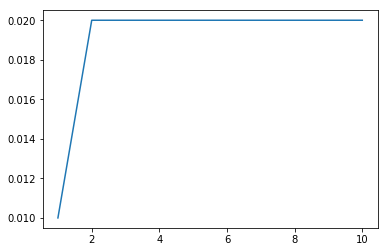

In [448]:
data['bigram'] = data['tit_text'].apply(bigram)
my_plot(10, data, data['bigram'])

С заменой

In [40]:
long = True

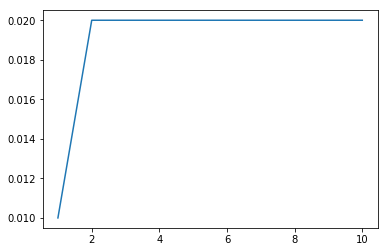

In [41]:
data['bigram2'] = data['tit_text'].apply(bigram)
my_plot(10, data, data['bigram2'])

С лемматизацией

In [451]:
lemm = True

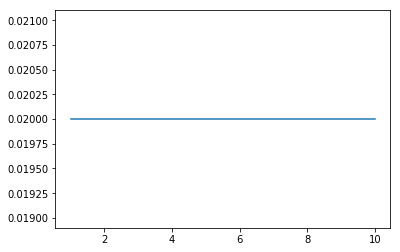

In [452]:
data['bigram3'] = data['tit_text'].apply(bigram)
my_plot(10, data, data['bigram3'])

Добавляем к нашим леммам

В общую кучу

In [42]:
def bigram_text(data):
    new = []
    for index, i in enumerate(data['content_norm6']):
        new.append(i + data['bigram2'][index])
    return new

In [43]:
data['bigram_text'] = bigram_text(data)

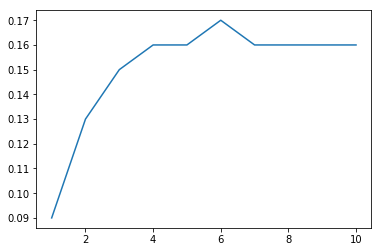

In [48]:
my_plot(10, data, data['bigram_text'])

In [49]:
evaluate(data['keywords'], data['bigram_text'].apply(lambda x: [x[0] for x in Counter(x).most_common(6)]))

0.17

In [50]:
data['bigram_text'].apply(lambda x: [x[0] for x in Counter(x).most_common(6)]).head(10)

0    [яблоко, молодёжный, акция, активист, молодёжное яблоко, деятельность]
1                               [миллиард, газа, куб, газпром, метр, куб м]
2                     [книга, роман, мир, перевод, стихотворение, читатель]
3                               [ким, зинаида, видео, журналист, суд, дело]
4                         [территория, москва, площадь, га, столица, тинао]
5                         [гонка, команда, место, позиция, круг, чемпионат]
6                       [место, влияние, позиция, глава, президент, сергей]
7                    [культура, закон, сфера, концепция, проект, изменение]
8                          [газопровод, сирия, турция, газа, европа, катар]
9        [участник, террористический, организация, калужский, область, фсб]
Name: bigram_text, dtype: object

В ключевые слова попало, например, словосочетание 'молодежное яблоко', которое действительно есть в ключевых словах

In [54]:
data.loc[0]['keywords']

['яблоко', 'молодежь', 'молодежное яблоко']

## Улучшение способа представления текста в виде графа

In [91]:
from itertools import combinations
import networkx as nx

In [64]:
def build_matrix(text, window_size=5):
    vocab = set(text)
    word2id = {w:i for i, w in enumerate(vocab)}
    id2word = {i:w for i, w in enumerate(vocab)}
    # преобразуем слова в индексы для удобства
    ids = [word2id[word] for word in text]

    # создадим матрицу совстречаемости
    m = np.zeros((len(vocab), len(vocab)))

    # пройдемся окном по всему тексту
    for i in range(0, len(ids), window_size):
        window = ids[i:i+window_size]
        # добавим единичку всем парам слов в этом окне
        for j, k in combinations(window, 2):
            # чтобы граф был ненаправленный 
            m[j][k] += 1
            m[k][j] += 1
    
    return m, id2word

def some_centrality_measure3(text, func, window_size=5, topn=5):
    
    matrix, id2word = build_matrix(text, window_size)
    G = nx.from_numpy_array(matrix)
    # тут можно поставить любую метрику
    node2measure = dict(func(G)) # degree_centrality  dict(nx.degree(G))
                                                    #dict(nx.betweenness_centrality(G))
    
    return [id2word[index] for index,measure in sorted(node2measure.items(), key=lambda x: -x[1])[:topn]]


Влияние числа предсказываемых слов:

In [80]:
def nx_plot(data, position, func, window=False, top=False):
    
    if window:
        res = {}
        for i in range(1, window+1):
            keyword_nx = position.apply(lambda x: some_centrality_measure3(x, func, i, 10))
            score = evaluate(data['keywords'], keyword_nx)
            res[i] = score
    
    if top:
        res = {}
        for i in range(1, top+1):
            keyword_nx = position.apply(lambda x: some_centrality_measure3(x, func, 5, i))
            score = evaluate(data['keywords'], keyword_nx)
            res[i] = score
    
    if window and top:
        res = {}
        for i in range(1, top+1):
            for l in range(1, window+1):
                keyword_nx = position.apply(lambda x: some_centrality_measure3(x, func, l, i))
                score = evaluate(data['keywords'], keyword_nx)
                res[str(i) + '-' + str(l)] = score

    print(sorted(res.items(), key=lambda x: x[1], reverse=True)[:10])
    fig = plt.figure()
    plt.plot(res.keys(), res.values())
    plt.show()


Перебор параметров

Без bigram

Без замены рф-россия

[('5-3', 0.17), ('5-4', 0.17), ('5-8', 0.17), ('5-9', 0.17), ('5-10', 0.17), ('6-3', 0.17), ('6-5', 0.17), ('6-6', 0.17), ('6-7', 0.17), ('6-8', 0.17)]


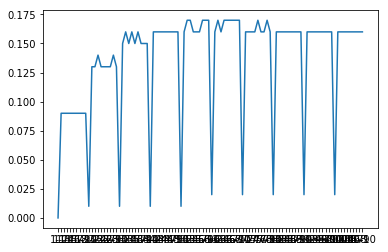

In [81]:
nx_plot(data, data['content_norm4'], nx.degree, window=10, top=10)

C заменой

[('4-3', 0.16), ('4-4', 0.16), ('4-5', 0.16), ('4-9', 0.16), ('5-2', 0.16), ('5-3', 0.16), ('5-4', 0.16), ('5-5', 0.16), ('5-6', 0.16), ('5-7', 0.16)]


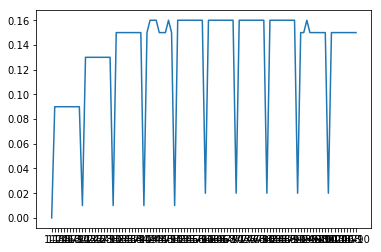

In [82]:
nx_plot(data, data['content_norm6'], nx.degree, window=10, top=10)

С биграмами

[('4-2', 0.16), ('4-3', 0.16), ('4-4', 0.16), ('4-5', 0.16), ('4-6', 0.16), ('4-8', 0.16), ('4-10', 0.16), ('5-2', 0.16), ('5-3', 0.16), ('5-4', 0.16)]


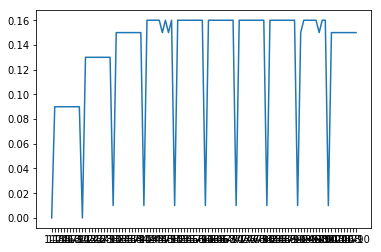

In [84]:
nx_plot(data, data['bigram_text'], nx.degree, window=10, top=10)

Влияние метрики:

In [85]:
funcs = [nx.degree_centrality, nx.degree, nx.eigenvector_centrality, nx.closeness_centrality,
        nx.load_centrality, nx.harmonic_centrality, nx.betweenness_centrality]

In [97]:
id_func = {0:'degree_centrality', 1:'degree', 2:'eigenvector_centrality',
           3:'closeness_centrality', 4:'load_centrality', 5:'harmonic_centrality',
          6:'betweenness_centrality'}

In [102]:
res = {}

for index, func in enumerate(funcs):
    try:
        print(func)
        keyword_nx = data['content_norm4'].apply(lambda x: some_centrality_measure3(x, func, 3, 5))
        score = evaluate(data['keywords'], keyword_nx)
        res[id_func[index]] = score
    except:
        continue

<function degree_centrality at 0x113f9fd08>
<function degree at 0x113f37bf8>
<function eigenvector_centrality at 0x113fa8510>
<function closeness_centrality at 0x113f92730>
<function newman_betweenness_centrality at 0x113f86b70>
<function harmonic_centrality at 0x113fa82f0>
<function betweenness_centrality at 0x113f89bf8>


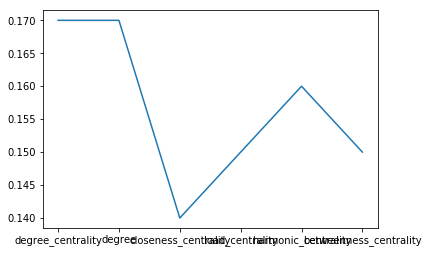

In [103]:
fig = plt.figure()
plt.plot(res.keys(), res.values())
plt.show()

## Rake

In [104]:
from rake_nltk import Metric, Rake

In [134]:
r = Rake(language='russian', stopwords=stops, max_length=2)

Сами по себе

In [165]:
def rake_words(position):    
    
    global r
    
    ans = []

    r.extract_keywords_from_text(position)

    for word in r.get_ranked_phrases():
        if len(word.split(' ')) == 1:
            word = morph.parse(word)[0]
            if word.normal_form not in stops:
                if word.tag.POS == 'NOUN' or word.tag.POS == 'ADJF':
                    ans.append(word.normal_form)
        elif len(word.split(' ')) > 1:
            ans.append(word)
    return ans

In [166]:
data['rake_words'] = data['tit_text'].apply(rake_words)
evaluate(data['keywords'], data['rake_words'].apply(lambda x: [x[0] for x in Counter(x).most_common(5)]))

0.07

В сочетании с нашими ключевыми словами

In [219]:
def rake_text(data, n):
    new = []
    for index, i in enumerate(data['bigram_text']):
        y = [x[0] for x in Counter(i).most_common(n)]
        new.append(set(y) & set(data['rake_words'][index]))
    return new

data['rake_text'] = rake_text(data, 10)

In [220]:
evaluate(data['keywords'], data['rake_text'].apply(lambda x: [x[0] for x in Counter(x).most_common(10)]))

0.16